In [1]:
import numpy as np
import osmnx as ox
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

import random
import pickle
import pymde
from sklearn.manifold import MDS, Isomap, TSNE, LocallyLinearEmbedding, SpectralEmbedding
from scipy import sparse

import mlrfit as mf
import lrrouting as ldr

import cvxpy as cp
import numba as nb

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

#  Matrix definition

In [3]:
rank = 6

mtype = "small_world"
n = 5020
# G = nx.connected_watts_strogatz_graph(n, k=4, p=0.1)
# G.remove_edges_from(nx.selfloop_edges(G))
# G = nx.DiGraph(G)

beta = 0.8
gamma = 0.01
G = nx.scale_free_graph(n, alpha=1-beta-gamma, beta=beta, gamma=gamma)#alpha=0.41, beta=0.54)

n = G.number_of_nodes()
print(f"{n=}, {G.number_of_edges()=}")

# for u, v in G.edges():
#     G[u][v]['weight'] = np.random.rand() * 10

Adj, Dist, nodes_cc = ldr.nx_graph_to_matrices(G, nodes=True)
G = G.subgraph(nodes_cc)
n = G.number_of_nodes()
A = Dist

n=5020, G.number_of_edges()=25162
[496, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

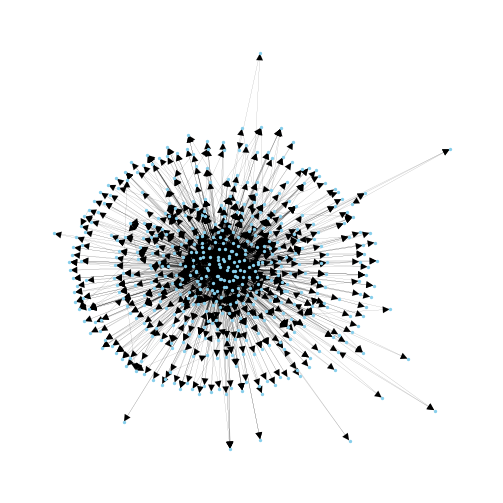

In [4]:
ldr.plot_nx_G(G, with_labels=False, node_size=1, f_layout=nx.spring_layout, width=0.05)

In [5]:
assert nx.is_strongly_connected(G)
np.histogram(Dist.flatten(), bins=5, density=True)

(array([6.67623869e-02, 2.90404814e-01, 2.47497974e-02, 2.63428770e-03,
        6.40983951e-05]),
 array([ 0. ,  2.6,  5.2,  7.8, 10.4, 13. ]))

In [6]:
adjacency_list = ldr.adjacency_directed_list(Adj)
sources, targets = ldr.st_pairs(n, Dist, 1020)
M = min(1000, sources.size)
sources = sources[:M]
targets = targets[:M]

In [7]:
PSD = False
w_min = A[A>0].min()
rt_max_iters = min(int(5*A.max()/w_min), (10**4) // 2)
symm = np.allclose(A, A.T)
print(f"{symm=}")
filename = "%s_r%d_%d"%(mtype, rank, n)

symm=False


In [8]:
np.histogram(Adj[Adj>0], bins=5, density=True)

(array([9.82858341e-03, 1.42926564e-05, 0.00000000e+00, 1.42926564e-05,
        4.76421881e-06]),
 array([  1. , 102.4, 203.8, 305.2, 406.6, 508. ]))

In [9]:
info = {} 

In [10]:
fraction_of_nodes = 0.5
pi_rows = np.random.permutation(n)[:int(n * fraction_of_nodes)]
pi_cols = np.random.permutation(n)[:int(n * fraction_of_nodes)+10]

pi_rows_c = np.delete(np.arange(n), pi_rows)
pi_cols_c = np.delete(np.arange(n), pi_cols)

pi_row_Dist = ldr.sparse_sampled_matrix(pi_rows, Dist, rows=True)
pi_col_Dist_T = ldr.sparse_sampled_matrix(pi_cols, Dist, rows=False)

rDist = np.zeros((n, n))
rDist[pi_rows] = Dist[pi_rows]
assert np.allclose(pi_row_Dist.toarray(), rDist)

cDist = np.zeros((n, n))
cDist[:, pi_cols] = Dist[:, pi_cols]
assert np.allclose(pi_col_Dist_T.T.toarray(), cDist)
print("PASSED")

rDist = Dist[pi_rows]
cDist = Dist[:, pi_cols].T

PASSED


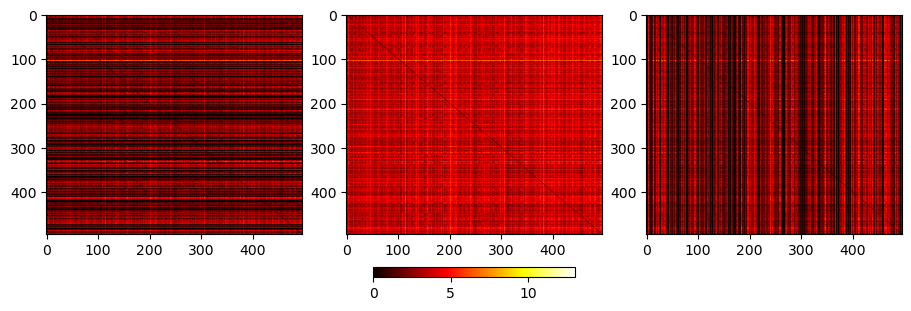

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

im1 = axs[0].imshow(pi_row_Dist.toarray(), aspect='auto', cmap='hot')
im2 = axs[1].imshow(Dist, aspect='auto', cmap='hot')
im3 = axs[2].imshow(pi_col_Dist_T.toarray().T, aspect='auto', cmap='hot')

fig.colorbar(im1, ax=axs, orientation='horizontal', fraction=0.046, pad=0.04, )

In [12]:
pi_rows.size

248

In [13]:
pi_rows_c = np.delete(np.arange(n), pi_rows)
assert (np.sort(np.concatenate([pi_rows, pi_rows_c])) == np.arange(n)).all()

In [14]:
# compute (B^k Z^k)
def product_BZ_forloop(pi_rows, pi_cols, rDist, cDist, X, Y, p, n):
    """
    X, Y: n x p/2 
        left and right embedding matrices of n items
    """
    res = np.empty((2*n, p//2), dtype=np.double)
    d_X = np.einsum('ik,ik->i', X, X).reshape(-1, 1)
    d_Y = np.einsum('ik,ik->i', Y, Y).reshape(-1, 1)
    for t, i in enumerate(pi_rows):
        dist_i_all = np.sqrt(d_X[i] - 2 * X[i:i+1] @ Y.T + d_Y.T)
        ratios = np.divide(rDist[t:t+1], dist_i_all)
        # print(ratios.shape, ratios.sum(), X[i:i+1].shape, Y.shape )
        res[i:i+1] = ratios.sum() * X[i:i+1] - ratios @ Y 
    assert dist_i_all.shape == (1, n)

    for t, j in enumerate(pi_cols):
        dist_j_all = np.sqrt(d_Y[j] - 2 * Y[j:j+1] @ X.T + d_X.T)
        ratios = np.divide(cDist[t:t+1], dist_j_all)
        res[n+j:n+j+1] = ratios.sum() * Y[j:j+1] - ratios @ X 
    assert dist_j_all.shape == (1, n)

    pi_rows_c = np.delete(np.arange(n), pi_rows)
    for i in pi_rows_c:
        dist_i_J = np.sqrt(d_X[i] - 2 * X[i:i+1] @ Y[pi_cols].T + d_Y[pi_cols].T)
        ratios = np.divide(cDist[:, i:i+1].T, dist_i_J)
        res[i:i+1] = ratios.sum() * X[i:i+1] - ratios @ Y[pi_cols] 
    assert dist_i_J.shape == (1, pi_cols.size)

    pi_cols_c = np.delete(np.arange(n), pi_cols)
    for j in pi_cols_c:
        dist_j_I = np.sqrt(d_Y[j] - 2 * Y[j:j+1] @ X[pi_rows].T + d_X[pi_rows].T)
        ratios = np.divide(rDist[:, j:j+1].T, dist_j_I)
        res[n+j:n+j+1] = ratios.sum() * Y[j:j+1] - ratios @ X[pi_rows] 
    assert dist_j_I.shape == (1, pi_rows.size)

    return res

In [15]:
d = np.random.randn(20)
A = np.random.randn(20, 20)
assert np.allclose(d[:, np.newaxis] * A, np.diag(d) @ A)

In [16]:
for _ in range(10):
    Z0 = np.random.randn(2*n, rank//2)
    res3 = ldr.form_B_compute_BZ(Z0, n, rDist, cDist, pi_rows, pi_cols)
    res1 = product_BZ_forloop(pi_rows, pi_cols, rDist, cDist, Z0[:n], Z0[n:], rank, n)
    X, Y = Z0[:n], Z0[n:]
    d_X = np.einsum('ik,ik->i', X, X)
    d_Y = np.einsum('ik,ik->i', Y, Y)
    B = ldr.B_matrix(Z0, n, rDist, cDist, pi_rows, pi_cols)
    res_true = B @ Z0
    res2 = ldr.product_BZ(X, Y, d_X, d_Y, pi_rows, pi_cols, pi_rows_c, pi_cols_c, rDist, cDist)
    assert np.allclose(res1, res3) and np.allclose(res3, res2) and np.allclose(res3, res_true)
print("PASSED")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


PASSED


In [17]:
Z0 = np.random.randn(2*n, rank//2)

In [19]:
B = ldr.B_matrix(Z0, n, rDist, cDist, pi_rows, pi_cols)

B2 = np.zeros((2*n, 2*n))
dists_ij = ldr.asymm_eulidean_dist_matrix(Z0[:n], Z0[n:])
for i in pi_rows:
    for j in range(n):
        ratio = Dist[i, j] / dists_ij[i, j]
        B2[i, i] += ratio
        B2[n+j, n+j] += ratio
        B2[i, n+j] = -ratio
        B2[n+j, i] = -ratio

for j in pi_cols:
    for i in range(n):
        ratio = Dist[i, j] / dists_ij[i, j]
        if np.allclose(B2[i, n+j], -ratio): continue
        B2[i, i] += ratio
        B2[n+j, n+j] += ratio
        B2[i, n+j] = -ratio
        B2[n+j, i] = -ratio

assert np.allclose(B, B2) and (np.allclose(np.linalg.norm(B.sum(axis=0)), 0) and np.allclose(np.linalg.norm(B.sum(axis=1)), 0))
assert (np.allclose(np.linalg.norm(B2.sum(axis=0)), 0) and np.allclose(np.linalg.norm(B2.sum(axis=1)), 0))
print("PASSED")

PASSED


In [20]:
res1 = product_BZ_forloop(pi_rows, pi_cols, rDist, cDist, Z0[:n], Z0[n:], rank, n)
res2 = B @ Z0
assert np.allclose(res1, res2)
print("PASSED")

PASSED


In [21]:
X, Y = Z0[:n], Z0[n:]

d_X = np.einsum('ik,ik->i', X, X)
d_Y = np.einsum('ik,ik->i', Y, Y)

res = ldr.product_BZ(X, Y, d_X, d_Y, pi_rows, pi_cols, pi_rows_c, pi_cols_c, rDist, cDist)

res_true = B @ Z0
assert np.allclose(res, res_true)
print("PASSED")

PASSED


In [22]:
for _ in range(10):
    Z0 = np.random.randn(2*n, rank//2)
    X, Y = Z0[:n], Z0[n:]

    d_X = np.einsum('ik,ik->i', X, X)
    d_Y = np.einsum('ik,ik->i', Y, Y)
    
    res = ldr.product_BZ(X, Y, d_X, d_Y, pi_rows, pi_cols, pi_rows_c, pi_cols_c, rDist, cDist)

    B = ldr.B_matrix(Z0, n, rDist, cDist, pi_rows, pi_cols)
    res_true = B @ Z0
    assert np.allclose(res, res_true), print(mf.rel_diff(res, res_true))
print("PASSED")

PASSED


In [23]:
%timeit ldr.product_BZ(X, Y, d_X, d_Y, pi_rows, pi_cols, pi_rows_c, pi_cols_c, rDist, cDist)

55.8 ms ± 14.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
%timeit product_BZ_forloop(pi_rows, pi_cols, rDist, cDist, Z0[:n], Z0[n:], rank, n)

88.3 ms ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%timeit ldr.form_B_compute_BZ(Z0, n, rDist, cDist, pi_rows, pi_cols)

19.6 ms ± 7.02 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


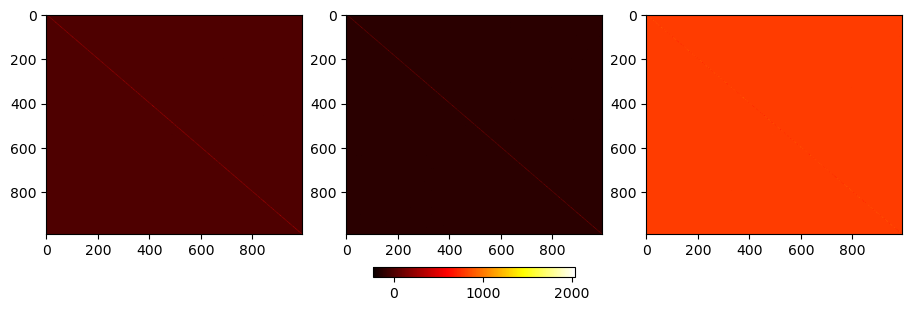

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

im1 = axs[0].imshow(B, aspect='auto', cmap='hot')
im2 = axs[1].imshow(B2, aspect='auto', cmap='hot')
im3 = axs[2].imshow(B2-B, aspect='auto', cmap='hot')

fig.colorbar(im1, ax=axs, orientation='horizontal', fraction=0.046, pad=0.04, )